# Diagnosing model performance

### Objectives
- Diagnosing model performance by introducing a novel efficiency measure based on flow duration curve
- Flow duration curve covers different processes (e.g. runoff generation, storage recession)

This notebook demonstrates the usage of DE and provides a proof of concept.

## Data
We use observed streamflow data from the CAMELS dataset (Newman et al. 2015).

In [1]:
import datetime as dt
import numpy as np
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Polygon
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import scipy as sp
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})  # controlling figure aesthetics
from de import de
from de import util
import warnings
warnings.filterwarnings('ignore')

First, we import a daily observed streamflow time series and plot the time series:

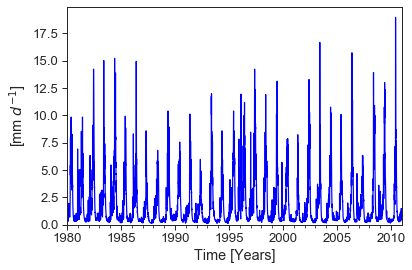

In [2]:
# Import a function that deals with paths properly, regardless of OS
from pathlib import Path  

path = Path('/Users/robinschwemmle/Desktop/PhD/diagnostic_model_efficiency/examples/camels_example_data/13331500_streamflow_qc.txt')
df_ts = util.import_camels_ts(path, sep=r"\s+") # import observed time series
de.plot_ts(df_ts)

### 2-D plots of DE and KGE

## Proof of concept
In order to mimick model errors or input data errors, respectively, we manipulate the observed time series:
1. Mimicking dynamic errors
2. Mimicking constant errors
3. Mimicking timing errors
4. Combination of 1., 2., and 3.
5. Mean flow benchmark

### 1. Mimicking dynamic errors

#### Increase high flows - Decrease low flows

We generate a new by time series by increasing high flows and decreasing low flows. In particular we tilt the flow duration curve around the median value (i.e. $Q_{50}$). This results in steeper gradient of the flow duration curve (see the upper figure below; red curve).

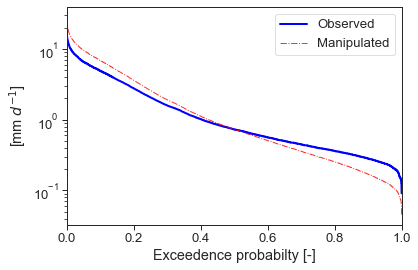

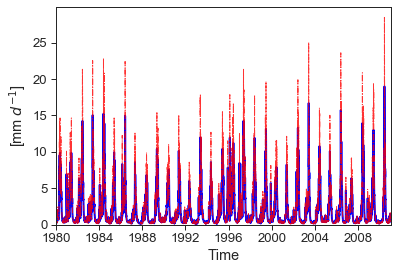

In [4]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highover_lowunder(df_ts.copy(), prop=0.5)
obs_sim.loc[:, 'Qsim'] = tsd.loc[:, 'Qsim']  # disaggregated time series
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

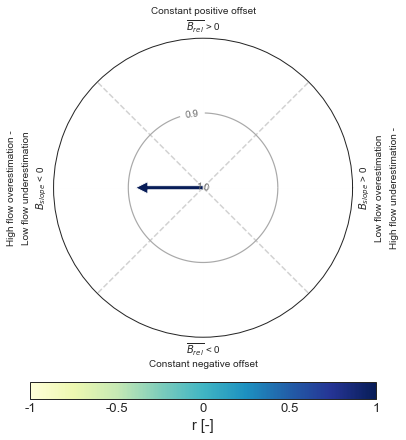

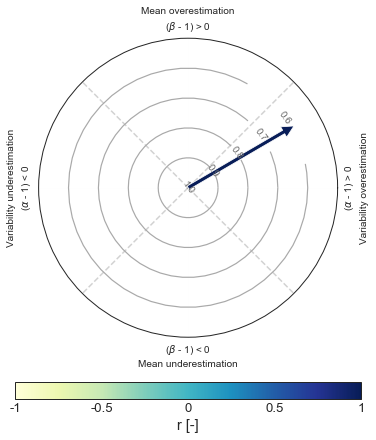

In [5]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [6]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.91
KGE: 0.43
NSE: 0.7


The upper figure shows the result for the linear regression for relativa Biases.

The figure in the middle represents the visualisation of the DE in the 2D-space which gives evidence that the model structure/parameterisation is deficient resulting in a DE which is 0.

The lower figure represents the KGE in a 2D-space.

#### Decrease high flows - Increase low flows

We generate a new by time series by decreasing high flows and increasing low flows. We tilt the flow duration curve around the median value (i.e. $Q_{50}$). This results in a flatter gradient of the flow duration curve (see the upper figure below; red curve).

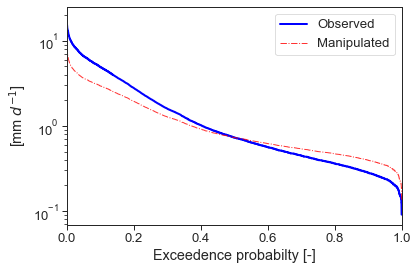

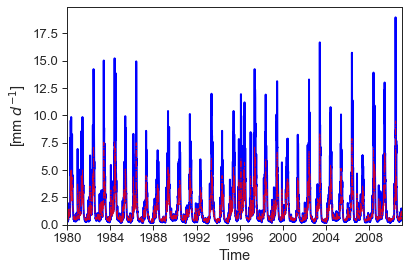

In [7]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)
obs_sim.loc[:, 'Qsim'] = tsd.loc[:, 'Qsim']  # smoothed time series
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

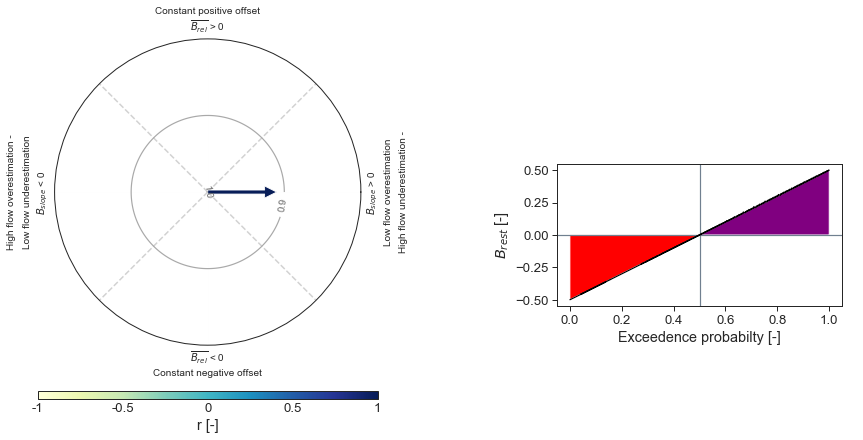

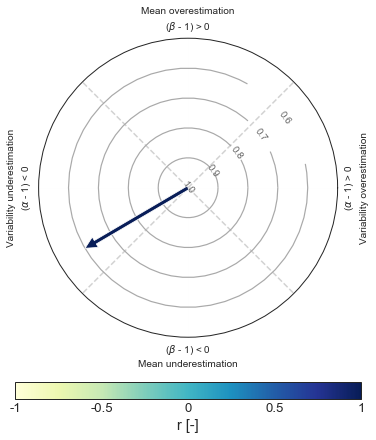

In [8]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr, extended=True)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [9]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.91
KGE: 0.43
NSE: 0.7


### 2. Mimicking constant errors

#### Constant positive offset
Constant positive offset is imitated by multplying the time series with a constant offset of 1.5 (see the upper figure below; red curve). Generally, the offset has to be greater than 1.

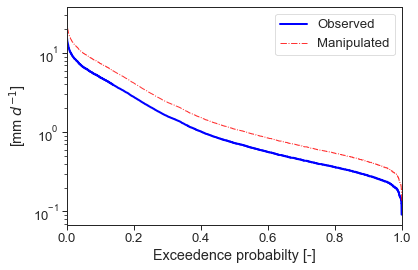

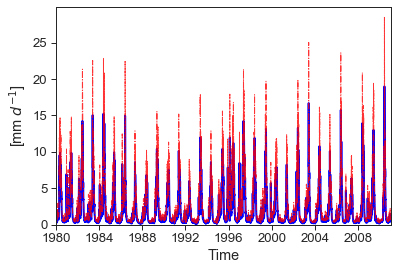

In [10]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_sim.loc[:, 'Qsim'] = de.shift_ts(df_ts['Qobs'].values, offset=1.5)  # positive offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

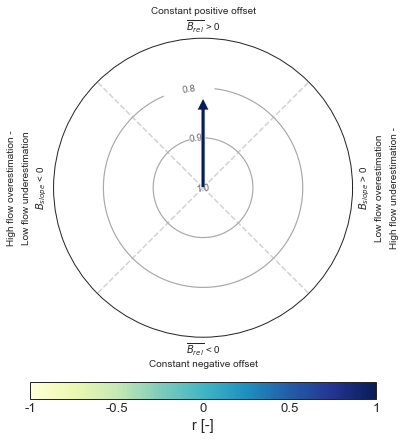

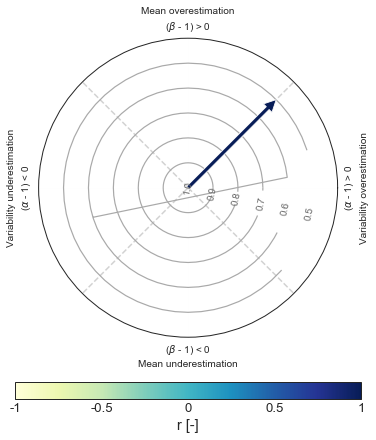

In [11]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [12]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.82
KGE: 0.29
NSE: 0.6


#### Constant negative offset
Constant negative offset is imitated by multplying the time series with a constant offset of 0.5 (see the upper figure below; red curve). Generally, the offset has to be less than 1.

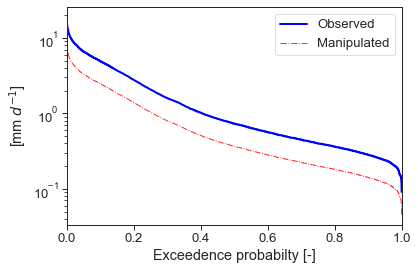

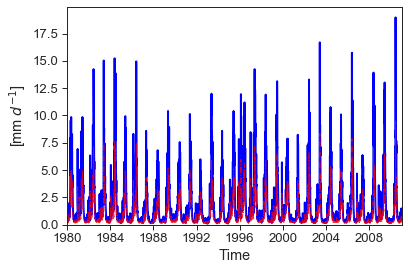

In [13]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_sim.loc[:, 'Qsim'] = de.shift_ts(df_ts['Qobs'].values, offset=0.5)  # negative offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

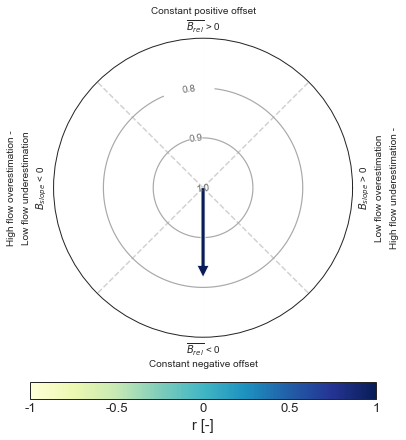

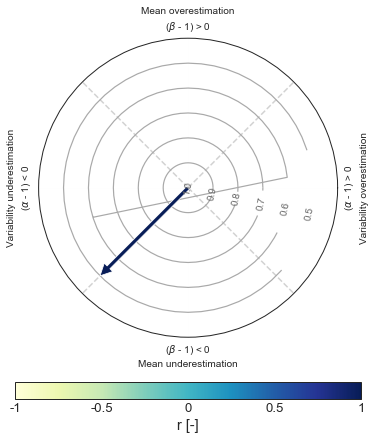

In [14]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [15]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.82
KGE: 0.29
NSE: 0.6


### Mimicking timing errors

#### Shuffling 

We shuffle the time series.

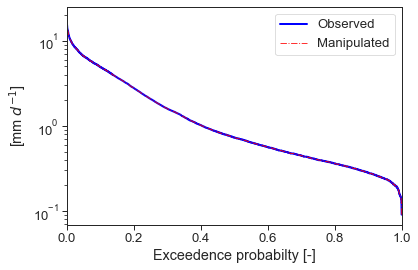

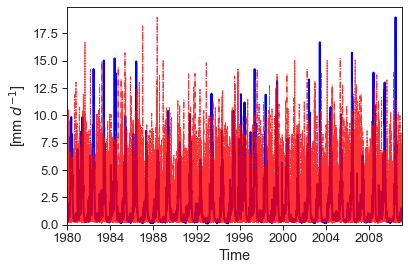

In [16]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tss = de.time_shift(df_ts.copy(), random=True)  # shuffled time series
obs_sim.loc[:, 'Qsim'] = tss.iloc[:, 0].values
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

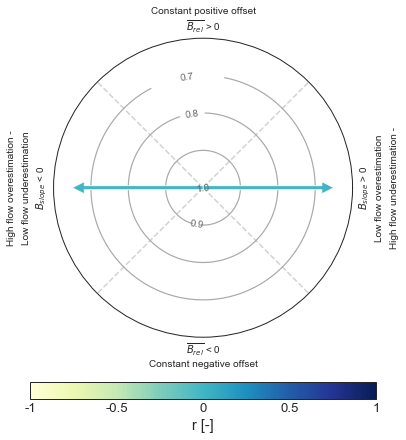

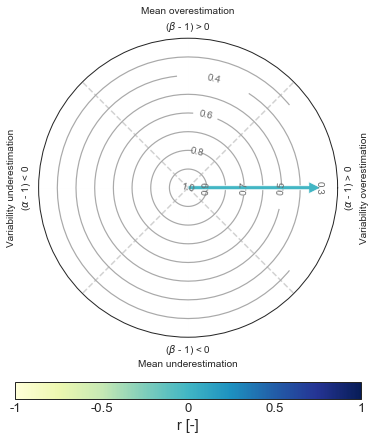

In [17]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [18]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.65
KGE: -0.0
NSE: -1.01


### Combination of 1. and 2.

#### Decrease high flows - Increase low flows and constant positive offset
First, we tilt the flow duration curve around its median (i.e. $Q_{50}$) by decreasing high flows and increasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 1.5.

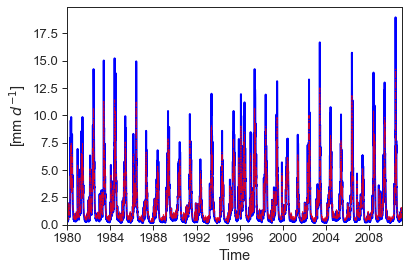

In [19]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)  # smoothed time series
tso = de.shift_ts(obs_sim.iloc[:, 0].values, offset=.25)  # P offset
obs_sim.loc[:, 'Qsim'] = tsd.iloc[:, 0].values + tso  # positive offsetde.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

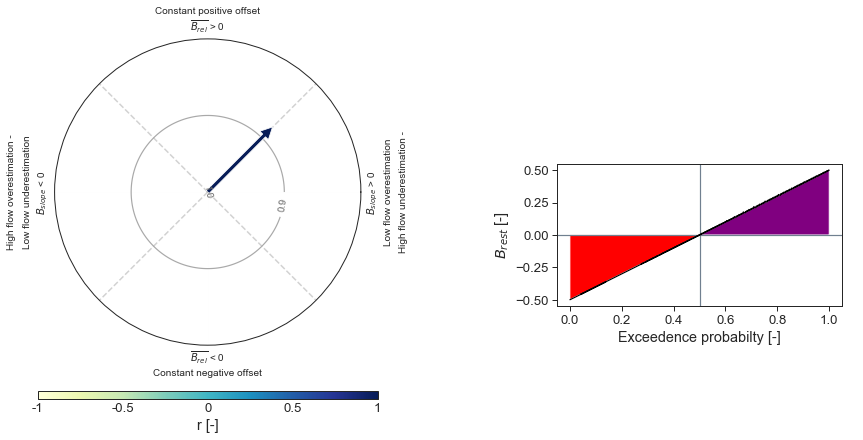

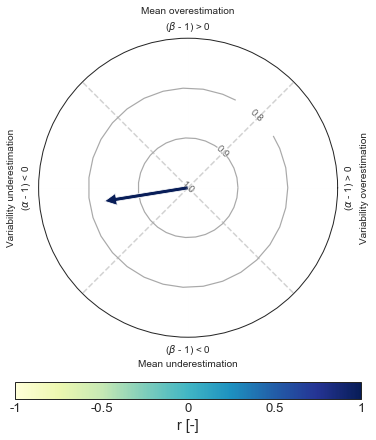

In [20]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr, extended=True)  # polar plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # polar plot of Kling-Gupta efficiency

In [21]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.88
KGE: 0.75
NSE: 0.94


#### Decrease high flows - Increase low flows and constant negative offset
First, we tilt the flow duration curve around its median (i.e. $Q_{50}$) by decreasing high flows and increasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 0.5.

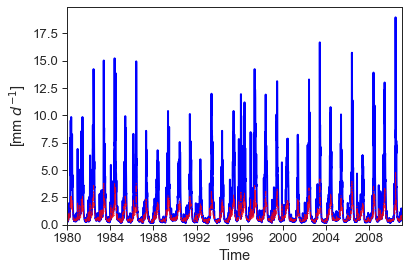

In [22]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)  # smoothed time series
tso = de.shift_ts(obs_sim.iloc[:, 0].values, offset=.25)  # P offset
obs_sim.loc[:, 'Qsim'] = tsd.iloc[:, 0].values - tso  # negative offsetde.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

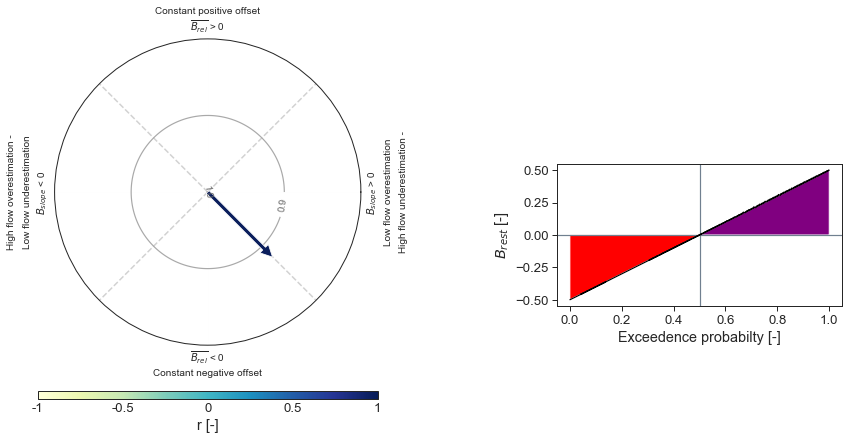

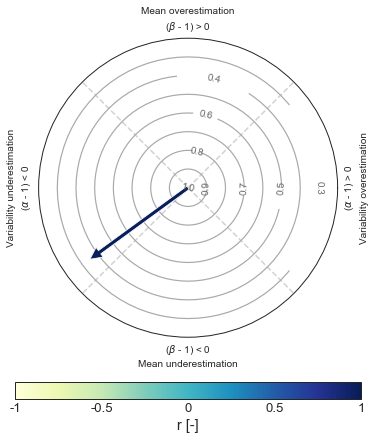

In [23]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr, extended=True)  # polar plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # polar plot of Kling-Gupta efficiency

In [24]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.88
KGE: 0.08
NSE: 0.27


#### Increase high flows - Decrease low flows and constant positive offset
First, we tilt the flow duration curve around its median (i.e. $Q_{50}$) by increasing high flows and decreasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 1.5.

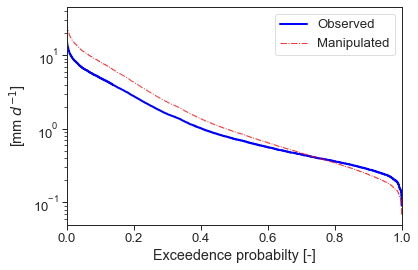

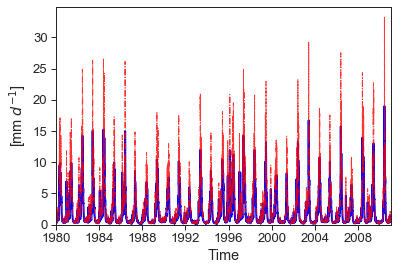

In [25]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highover_lowunder(df_ts.copy(), prop=0.5)  # disaggregated time series
tso = de.shift_ts(obs_sim.iloc[:, 0].values, offset=.25)  # P offset
obs_sim.loc[:, 'Qsim'] = tsd.iloc[:, 0].values + tso  # positive offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

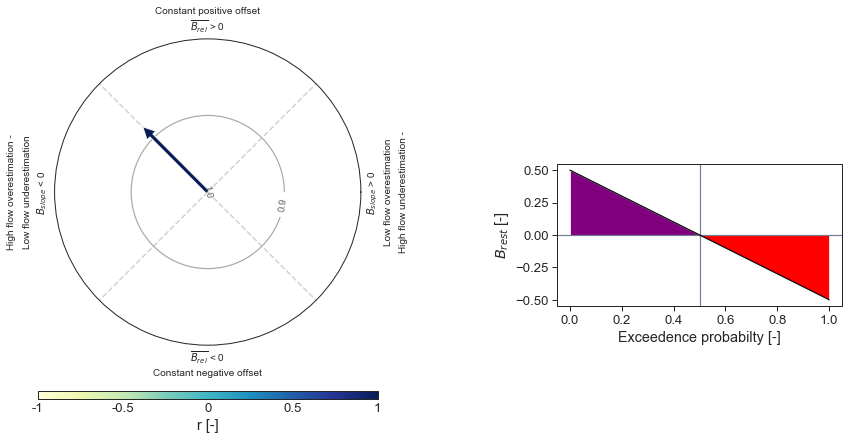

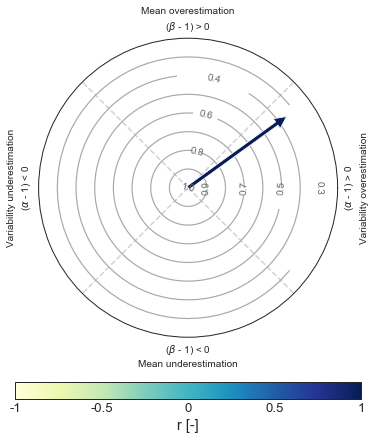

In [26]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr, extended=True)  # polar plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # polar plot of Kling-Gupta efficiency

In [27]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.88
KGE: 0.08
NSE: 0.27


#### Increase high flows - Decrease low flows and constant negative offset
First, we tilt the flow duration curve around its median (i.e. $Q_{50}$) by increasing high flows and decreasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 0.5.

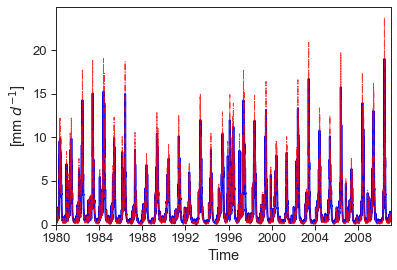

In [28]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highover_lowunder(df_ts.copy(), prop=0.5) # disaggregated time series
tso = de.shift_ts(obs_sim.iloc[:, 0].values, offset=.25)  # P offset
obs_sim.loc[:, 'Qsim'] = tsd.iloc[:, 0].values - tso  # negative offsetde.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

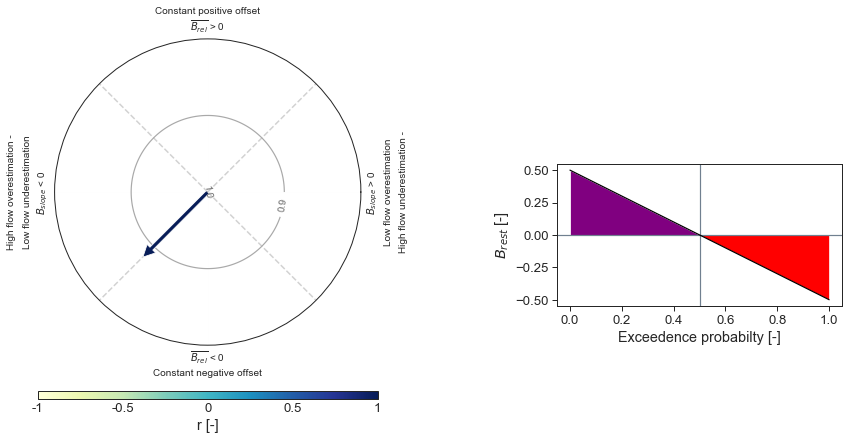

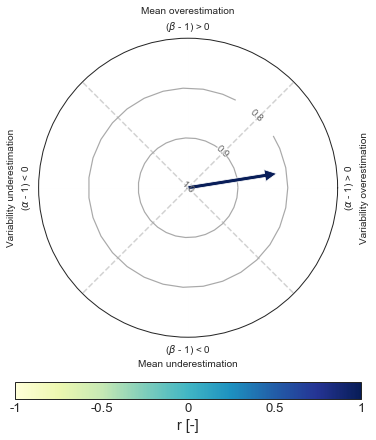

In [29]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr, extended=True)  # polar plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # polar plot of Kling-Gupta efficiency

In [30]:
# print DE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print KGE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.88
KGE: 0.75
NSE: 0.94


### Combination of 1., 2. and 3.

#### Decrease high flows - Increase low flows,  constant positive offset and shuffling

First, we tilt the flow duration curve around its median (i.e. 𝑄50) by decreasing high flows and increasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 1.5 and finally we shift the time series 3 days forward.

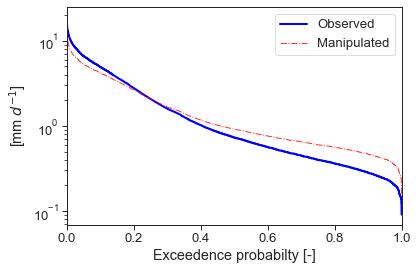

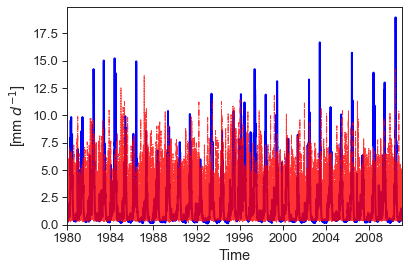

In [31]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=.5)  # smoothed time series
tsp = pd.DataFrame(index=df_ts.index, columns=['Qsim'])
tso = de.shift_ts(obs_sim.iloc[:, 0].values, offset=.25)  # P offset
tsp.iloc[:, 0]  = tsd.iloc[:, 0].values + tso  # negative offset
tst = de.time_shift(tsp, random=True)  # shuffling
obs_sim.loc[:, 'Qsim'] = tst.iloc[:, 0].values
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

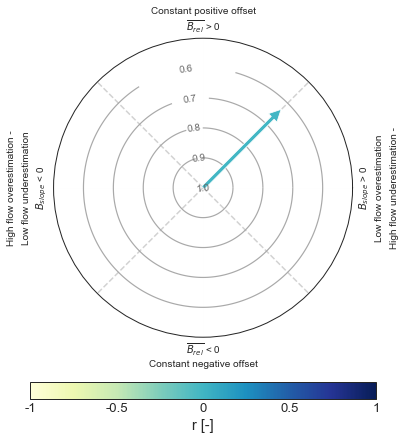

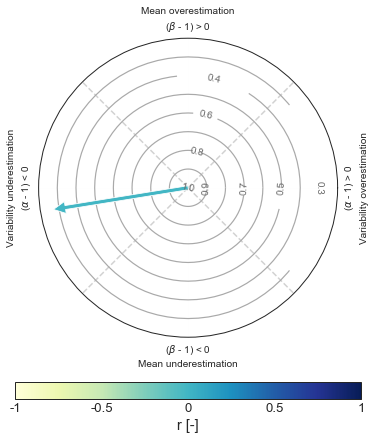

In [32]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # polar plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # polar plot of Kling-Gupta efficiency

In [33]:
# print DE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print KGE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.63
KGE: -0.03
NSE: -0.57


### Mean flow benchmark
Here, we adapt the mean flow benchmark from Knoben et al. (2019).

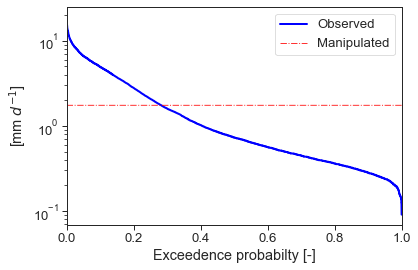

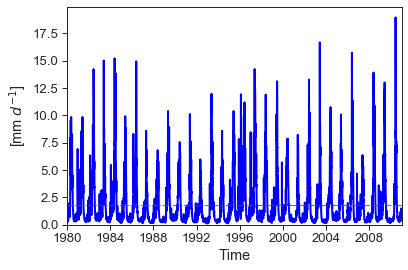

In [34]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_mean = np.mean(obs_sim['Qobs'].values)
obs_sim.loc[:, 'Qsim'] = np.repeat(obs_mean, len(obs_sim['Qobs'].values))
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

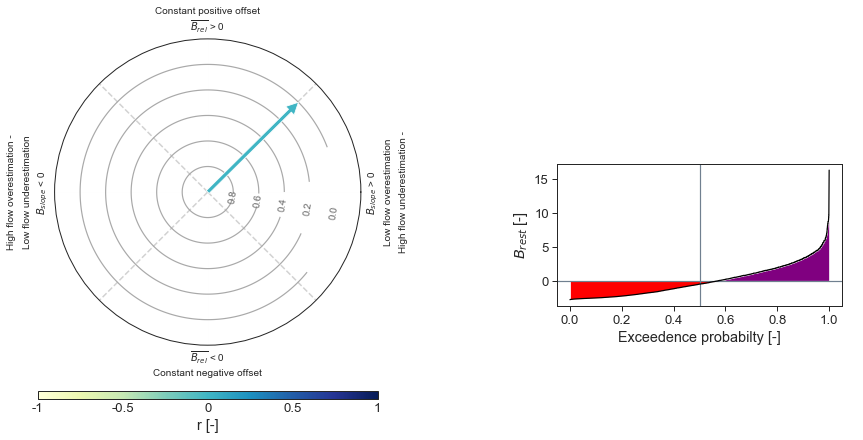

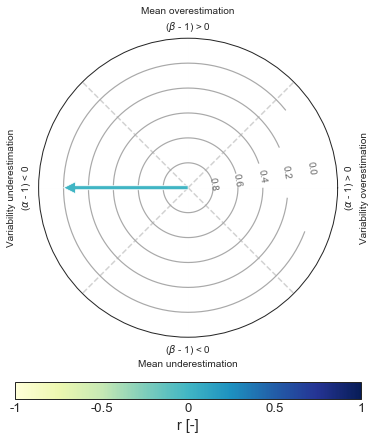

In [35]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr, extended=True)  # polar plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # polar plot of Kling-Gupta efficiency

In [36]:
# print DE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print KGE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.0
KGE: -0.41
NSE: 0.0


The mean average flow benchmark of DE is -0.25. Compared to the KGE and NSE benchmark it is substantially lower meaning that...

###  Real case example (CAMELS)
In order to prove the applicability of DE, we applied the approach to a real case. For this purpose, we used simulated runoff from the CAMELS dataset for the catchment with the ID 07373000 (Newman et al. 2015).

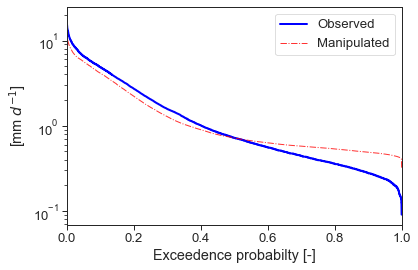

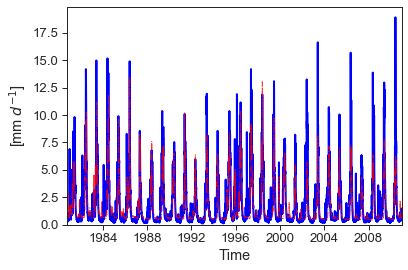

In [38]:
path_cam = Path('/Users/robinschwemmle/Desktop/PhD/diagnostic_model_efficiency/examples/camels_example_data/13331500_05_model_output.txt')
df_cam = util.import_camels_obs_sim(path_cam, sep=r"\s+") # import time series
de.fdc_obs_sim(df_cam['Qobs'], df_cam['Qsim'])
de.plot_obs_sim(df_cam['Qobs'], df_cam['Qsim'])

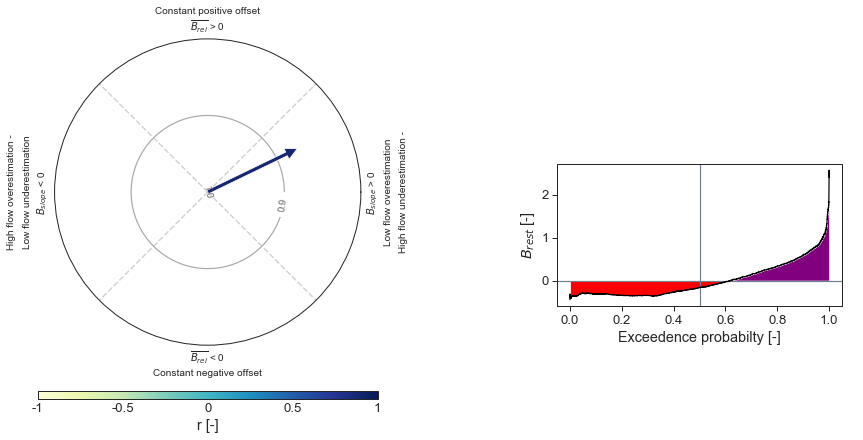

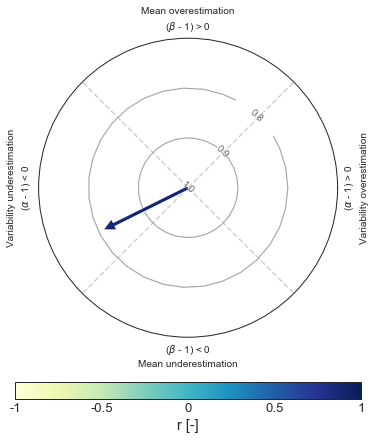

In [39]:
# make numpy arrays
obs_arr = df_cam['Qobs'].values  # observed time series
sim_arr = df_cam['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr, extended=True)  # polar plot of Diagnostic efficiency 
de.vis2d_kge_norm(obs_arr, sim_arr)  # polar plot of Kling-Gupta efficiency

In [40]:
# print DE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print KGE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.87
KGE: 0.74
NSE: 0.77


## References

Fowler, K., Peel, M., Western, A., and Zhang, L.: Improved Rainfall-Runoff Calibration for Drying Climate: Choice of Objective Function, Water Resources Research, 54, 3392-3408, 10.1029/2017wr022466, 2018.

Gupta, H. V., Kling, H., Yilmaz, K. K., and Martinez, G. F.: Decomposition of the mean squared error and NSE performance criteria: Implications for improving hydrological modelling, Journal of Hydrology, 377, 80-91, 10.1016/j.jhydrol.2009.08.003, 2009.

Kling, H., Fuchs, M., and Paulin, M.: Runoff conditions in the upper Danube basin under an ensemble of climate change scenarios, Journal of Hydrology, 424-425, 264-277, 10.1016/j.jhydrol.2012.01.011, 2012.

Knoben, W. J. M., Freer, J. E., and Woods, R. A.: Technical note: Inherent benchmark or not? Comparing Nash-Sutcliffe and Kling-Gupta efficiency scores, Hydrol. Earth Syst. Sci. Discuss., 2019, 1-7, 10.5194/hess-2019-327, 2019.

Nash, J. E., and Sutcliffe, J. V.: River flow forecasting through conceptual models part I - A discussion of principles, Journal of Hydrology, 10, 282-290, 10.1016/0022-1694(70)90255-6, 1970.

Newman, A. J., Clark, M. P., Sampson, K., Wood, A., Hay, L. E., Bock, A., Viger, R. J., Blodgett, D., Brekke, L., Arnold, J. R., Hopson, T., and Duan, Q.: Development of a large-sample watershed-scale hydrometeorological data set for the contiguous USA: data set characteristics and assessment of regional variability in hydrologic model performance, Hydrol. Earth Syst. Sci., 19, 209-223, 10.5194/hess-19-209-2015, 2015.

Pool, S., Vis, M., and Seibert, J.: Evaluating model performance: towards a non-parametric variant of the Kling-Gupta efficiency, Hydrological Sciences Journal, 63, 1941-1953, 10.1080/02626667.2018.1552002, 2018.

Schaefli, B., and Gupta, H. V.: Do Nash values have value?, Hydrological Processes, 21, 2075-2080, 10.1002/hyp.6825, 2007.